# Data Analysis

## Load Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

pd.set_option("display.max_columns", None)


account = pd.read_csv('data/account.csv', dtype={'date':object, 'account_id':object, 'district_id':object})
card_dev = pd.read_csv('data/card_dev.csv', dtype={'issued':object, 'card_id':object, 'disp_id':object})
client = pd.read_csv('data/client.csv', dtype={'birth_number':object, 'district_id':object, 'client_id':object})
disposition = pd.read_csv('data/disp.csv', dtype={'disp_id':object, 'client_id':object, 'account_id':object})
district = pd.read_csv('data/district.csv', dtype={'code':object})
loan_dev = pd.read_csv('data/loan_dev.csv', dtype={'date':object, 'loan_id':object, 'account_id':object})
trans_dev = pd.read_csv('data/trans_dev.csv', 
                        dtype={'trans_id':object, 'account_id':object, 'date':object, 'type':object, 'operation':object, 'amount':float, 'balance':float, 'k_symbol':object, 'bank':object, 'account':float})

card_comp = pd.read_csv('kaggle/card_comp.csv', sep=';', dtype={'issued':object})
loan_comp = pd.read_csv('kaggle/loan_comp.csv', sep=';', dtype={'date':object})
trans_comp = pd.read_csv('kaggle/trans_comp.csv', sep=';',
                        dtype={'account_id':int, 'date':object, 'type':object, 'operation':object, 'amount':float, 'balance':float, 'k_symbol':object, 'bank':object, 'account':float})

data = pd.read_csv('data_processed/complete/data.csv')

## General Attribute Analysis

The data is organized in data tables so each table has an ammount of attributes that can be analised to better understand their significance.

In [2]:
print(f'''
account     shape: {account.shape}
client      shape: {client.shape}
disposition shape: {disposition.shape}
district    shape: {district.shape}
card        shape: {card_dev.shape}
loan        shape: {loan_dev.shape}
trans       shape: {trans_dev.shape}

data        shape: {data.shape}
''')


account     shape: (4500, 4)
client      shape: (5369, 3)
disposition shape: (5369, 4)
district    shape: (77, 16)
card        shape: (177, 4)
loan        shape: (328, 7)
trans       shape: (396685, 10)

data        shape: (328, 34)



In [3]:
def get_correlation(df):   
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    plt.subplots(figsize=(30,24))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    ax = sns.heatmap(corr, mask=mask, cmap=cmap, center=0,square=True, linewidths=.1, cbar_kws={"shrink": .5}, annot = True, annot_kws={"size": 12})

    y_lim = ax.get_ylim();
    ax.set_ylim(np.ceil(y_lim[0]), np.floor(y_lim[1]))
    
    plt.savefig('correlation.png')
    plt.show()

In [4]:
def plot_PCA(df, y):
    if y is not None:
        df = pd.concat([df, y], axis = 1)
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    if y is not None:
        targets = [-1, 1]
        colors = ['r', 'g']
        for target, color in zip(targets,colors):
            indicesToKeep = df['status'] == target
            ax.scatter(df.loc[indicesToKeep, 'principal component 1']
                    , df.loc[indicesToKeep, 'principal component 2']
                    , c = color)
        ax.legend(targets)
        ax.grid()
    else:
        ax.scatter(df['principal component 1'], df['principal component 2'])
        ax.grid()

In [5]:
def get_PCA(X):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(X)
    print(pca.explained_variance_ratio_)
    display(pca.components_)

    finalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
    return finalDf

In [6]:
def convert_date(df):
    aux = df.apply(lambda x: '19'+x[:2]+'-'+x[2:4]+'-'+x[4:])
    return pd.to_datetime(aux).dt.date


In [7]:
DISPLAY_PAIRPLOTS = False

## Account Analysis

In [8]:
display(account.head())
print(account.info())
display(account.describe())


,account_id,district_id,frequency,date
0,576,55,monthly issuance,930101
1,3818,74,monthly issuance,930101
2,704,55,monthly issuance,930101
3,2378,16,monthly issuance,930101
4,2632,24,monthly issuance,930102


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   account_id   4500 non-null   object
 1   district_id  4500 non-null   object
 2   frequency    4500 non-null   object
 3   date         4500 non-null   object
dtypes: object(4)
memory usage: 140.8+ KB
None


,account_id,district_id,frequency,date
count,4500,4500,4500,4500
unique,4500,77,3,1535
top,576,1,monthly issuance,930208
freq,1,554,4167,13


monthly issuance              4167
weekly issuance                240
issuance after transaction      93
Name: frequency, dtype: int64

<BarContainer object of 3 artists>

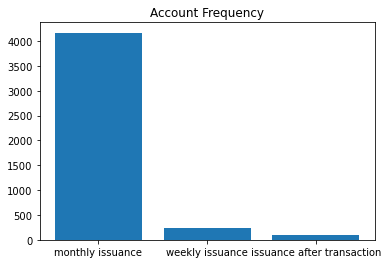

In [9]:
account_frequency = account["frequency"].value_counts()
display(account_frequency)

plt.title("Account Frequency")
plt.bar(list(account_frequency.keys()), list(account_frequency))

In [10]:
account['date_ts'] = convert_date(account['date'])
date_min = account['date_ts'].min()
date_max = account['date_ts'].max()
print("Account min date:", date_min)
print("Account max date:", date_max)
date_range = date_max-date_min
print("Account years range:", round(date_range.days/365.25, 2), 'years')

Account min date: 1993-01-01
Account max date: 1997-12-29
Account years range: 4.99 years


### Features conclusions
- Most of the `account frequency` values are "monthly issuance". Are the others values relevant to determine the `status`?
- Accounts `date` are between 1993 and 1997

## Card Analysis

In [11]:
display(card_dev.head())
display(card_dev.info())
display(card_dev.describe())


,card_id,disp_id,type,issued
0,1005,9285,classic,931107
1,104,588,classic,940119
2,747,4915,classic,940205
3,70,439,classic,940208
4,577,3687,classic,940215


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   card_id  177 non-null    object
 1   disp_id  177 non-null    object
 2   type     177 non-null    object
 3   issued   177 non-null    object
dtypes: object(4)
memory usage: 5.7+ KB


None

,card_id,disp_id,type,issued
count,177,177,177,177
unique,177,177,3,162
top,1005,9285,classic,960831
freq,1,1,127,2


classic    127
junior      41
gold         9
Name: type, dtype: int64

<BarContainer object of 3 artists>

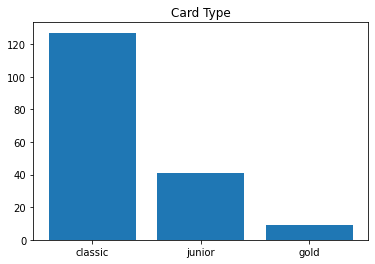

In [12]:
card_type = card_dev["type"].value_counts()
display(card_type)

plt.figure()
plt.title("Card Type")
plt.bar(list(card_type.keys()), list(card_type))

In [13]:
card_dev['issued_ts'] = convert_date(card_dev['issued'])
print(card_dev['issued_ts'].min())
print(card_dev['issued_ts'].max())

1993-11-07
1996-12-31


### Features conclusions
- Card `issued` dates are between 1993 and 1996

## Client Analysis

In [14]:
client = pd.read_csv('data_processed/client.csv', dtype={'birth_number':object, 'client_district_id':object, 'client_id':object})

In [15]:
display(client.head())
display(client.info())
display(client.describe())


,client_id,birth_number,client_district_id,gender
0,1,701213,18,Female
1,2,450204,1,Male
2,3,401009,1,Female
3,4,561201,5,Male
4,5,600703,5,Female


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5369 entries, 0 to 5368
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   client_id           5369 non-null   object
 1   birth_number        5369 non-null   object
 2   client_district_id  5369 non-null   object
 3   gender              5369 non-null   object
dtypes: object(4)
memory usage: 167.9+ KB


None

,client_id,birth_number,client_district_id,gender
count,5369,5369,5369,5369
unique,5369,4738,77,2
top,1,650725,1,Male
freq,1,4,663,2724


In [16]:
client['birth_number_ts'] = convert_date(client['birth_number'])
print(client['birth_number_ts'].min())
print(client['birth_number_ts'].max())

1911-08-20
1987-09-27


In [17]:
# merge client gender value counts and percentage
m, f = client['gender'].value_counts().values
print('Total clients: ', m+f)
print('Males:   {} %'.format(round(m/(m+f), 2)))
print('Females: {} %'.format(round(f/(m+f), 2)))


Total clients:  5369
Males:   0.51 %
Females: 0.49 %


### Features conclusions
- The oldest client is around 86 years old and youngest is 10 years old
- Clients `gender` are balanced

## Disposition Analysis

In [18]:
display(disposition.head())
display(disposition.info())
display(disposition.describe())


,disp_id,client_id,account_id,type
0,1,1,1,OWNER
1,2,2,2,OWNER
2,3,3,2,DISPONENT
3,4,4,3,OWNER
4,5,5,3,DISPONENT


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5369 entries, 0 to 5368
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   disp_id     5369 non-null   object
 1   client_id   5369 non-null   object
 2   account_id  5369 non-null   object
 3   type        5369 non-null   object
dtypes: object(4)
memory usage: 167.9+ KB


None

,disp_id,client_id,account_id,type
count,5369,5369,5369,5369
unique,5369,5369,4500,2
top,1,1,2369,OWNER
freq,1,1,2,4500


OWNER        4500
DISPONENT     869
Name: type, dtype: int64

<BarContainer object of 2 artists>

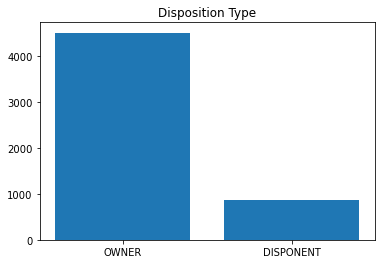

In [19]:
disp_type = disposition["type"].value_counts()
display(disp_type)

plt.figure()
plt.title("Disposition Type")
plt.bar(list(disp_type.keys()), list(disp_type))

In [20]:
n_clients = len(disposition['client_id'].unique())
n_dispositions = len(disposition['disp_id'].unique())
print('Is there any client with more than one disposition? {}'.format('Yes' if n_clients != n_dispositions else 'No'))

Is there any client with more than one disposition? No


### Features conclusions
- Every `client_id` corresponds to a single `disp_id` and vice-versa

## District Analysis

In [21]:
display(district.head())
display(district.info())
display(district.describe())
display(district.describe(include=object))


,code,name,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '95,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 16 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   code                                              77 non-null     object 
 1   name                                              77 non-null     object 
 2   region                                            77 non-null     object 
 3   no. of inhabitants                                77 non-null     int64  
 4   no. of municipalities with inhabitants < 499      77 non-null     int64  
 5   no. of municipalities with inhabitants 500-1999   77 non-null     int64  
 6   no. of municipalities with inhabitants 2000-9999  77 non-null     int64  
 7   no. of municipalities with inhabitants >10000     77 non-null     int64  
 8   no. of cities                                     77 non-null     int64  
 9   ratio of urban inhabita

None

,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '96
count,7.700000e+01,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,1.338849e+05,48.623377,24.324675,6.272727,1.727273,6.259740,63.035065,9031.675325,3.787013,116.129870,5030.831169
std,1.369135e+05,32.741829,12.780991,4.015222,1.008338,2.435497,16.221727,790.202347,1.908480,16.608773,11270.796786
min,4.282100e+04,0.000000,0.000000,0.000000,0.000000,1.000000,33.900000,8110.000000,0.430000,81.000000,888.000000
25%,8.585200e+04,22.000000,16.000000,4.000000,1.000000,5.000000,51.900000,8512.000000,2.310000,105.000000,2122.000000
50%,1.088710e+05,49.000000,25.000000,6.000000,2.000000,6.000000,59.800000,8814.000000,3.600000,113.000000,3040.000000
75%,1.390120e+05,71.000000,32.000000,8.000000,2.000000,8.000000,73.500000,9317.000000,4.790000,126.000000,4595.000000
max,1.204953e+06,151.000000,70.000000,20.000000,5.000000,11.000000,100.000000,12541.000000,9.400000,167.000000,99107.000000


,code,name,region,unemploymant rate '95,no. of commited crimes '95
count,77,77,77,77,77
unique,77,77,8,71,76
top,1,Hl.m. Praha,south Moravia,1.51,2854
freq,1,1,14,2,2


Hl.m. Praha      1
Svitavy          1
Hodonin          1
Breclav          1
Brno - venkov    1
                ..
Plzen - mesto    1
Klatovy          1
Karlovy Vary     1
Cheb             1
Vsetin           1
Name: name, Length: 77, dtype: int64

south Moravia      14
central Bohemia    12
east Bohemia       11
north Moravia      11
west Bohemia       10
north Bohemia      10
south Bohemia       8
Prague              1
Name: region, dtype: int64

<BarContainer object of 8 artists>

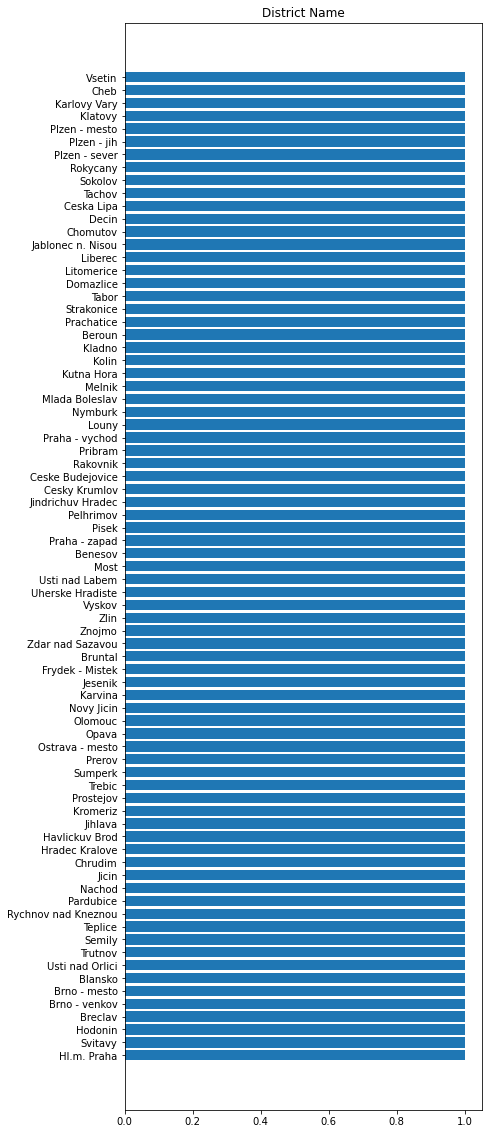

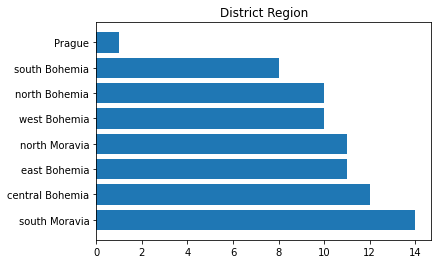

In [22]:
district_name = district["name"].value_counts()
display(district_name)
plt.figure(figsize=[6.4, 20])
plt.title("District Name")
plt.barh(list(district_name.keys()), list(district_name))

district_region = district["region"].value_counts()
display(district_region)
plt.figure()
plt.title("District Region")
plt.barh(list(district_region.keys()), list(district_region))

There was a row with missing values '?' in the district table for both "no. of commited crimes '95" and "unemploymant rate '95" columns. We needed to find a value for it, either replacing it with median or mean value of the column. To decide between median or mean, we need to analyse symmetry and the outliers of each column.

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff459258730>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff459258c70>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff459258460>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff459259180>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff459259450>],
 'means': []}

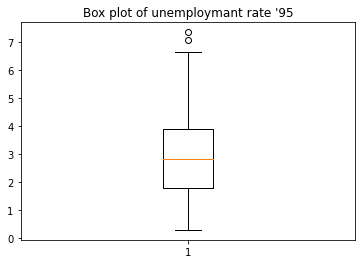

In [23]:
import matplotlib.pyplot as plt

district_clean = district.loc[(district["unemploymant rate '95"] != '?') & (district["no. of commited crimes '95"] != '?')]


plt.title("Box plot of unemploymant rate '95")
plt.boxplot(district_clean["unemploymant rate '95"].astype('float'))

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff459448820>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff459448dc0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff4594485b0>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff459449330>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff4594495d0>],
 'means': []}

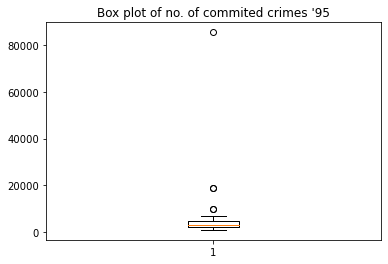

In [24]:
plt.title("Box plot of no. of commited crimes '95")
plt.boxplot(district_clean["no. of commited crimes '95"].astype('int'))

[9.99388112e-01 5.83845878e-04]


array([[ 3.66315012e-06, -2.39755883e-05, -2.51836171e-06,
         9.94373653e-01, -7.27702122e-05, -1.81420883e-05,
        -2.89870741e-06,  3.10454361e-07, -4.84526873e-06,
         5.33838535e-05,  3.67328822e-03, -1.13699485e-06,
        -1.62746671e-06,  3.20610065e-05,  6.97332681e-02,
         7.96542895e-02],
       [-4.32173938e-03, -1.57950570e-04, -1.76881899e-04,
        -1.05809389e-01,  4.08464733e-04, -1.59057048e-03,
        -5.91907451e-04, -9.48537994e-05, -1.35016601e-04,
        -3.16015027e-04,  1.86453399e-02, -1.03084625e-04,
        -9.52918307e-05,  1.77216901e-03,  6.20656703e-01,
         7.76670402e-01]])

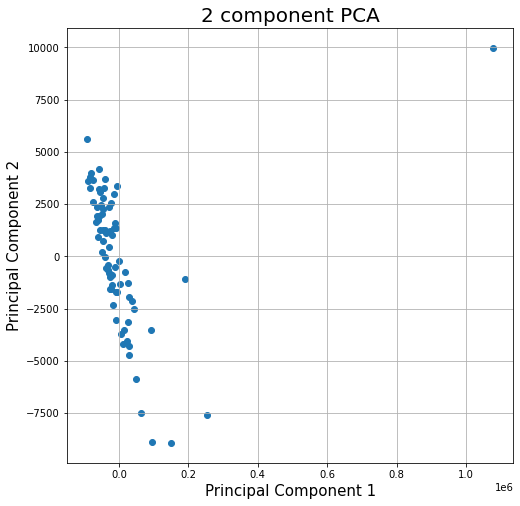

In [25]:
def replace_by_median(district):
    district_clean = district.loc[(district["unemploymant rate '95"] != '?') & (district["no. of commited crimes '95"] != '?')]
    median_unemploymant = district_clean["unemploymant rate '95"].astype(float).median()
    median_commited_crimes = district_clean["no. of commited crimes '95"].astype(int).median()

    # "no. of commited crimes '95" = '?' => median_commited_crimes
    # "unemploymant rate '95" = '?' => median_unemploymant
    district.loc[district["no. of commited crimes '95"] == '?', "no. of commited crimes '95"] = median_commited_crimes
    district.loc[district["unemploymant rate '95"] == '?', "unemploymant rate '95"] = median_unemploymant

enc_district = district.copy()
replace_by_median(enc_district)
from sklearn.preprocessing import OrdinalEncoder
le = OrdinalEncoder()
ordinal_cols = [col for col in ['name', 'region'] if col in enc_district.keys()]
enc_district[ordinal_cols] = le.set_params(encoded_missing_value=-1).fit_transform(enc_district[ordinal_cols])

df = get_PCA(enc_district)
plot_PCA(df, None)

/tmp/ipykernel_34416/635353890.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


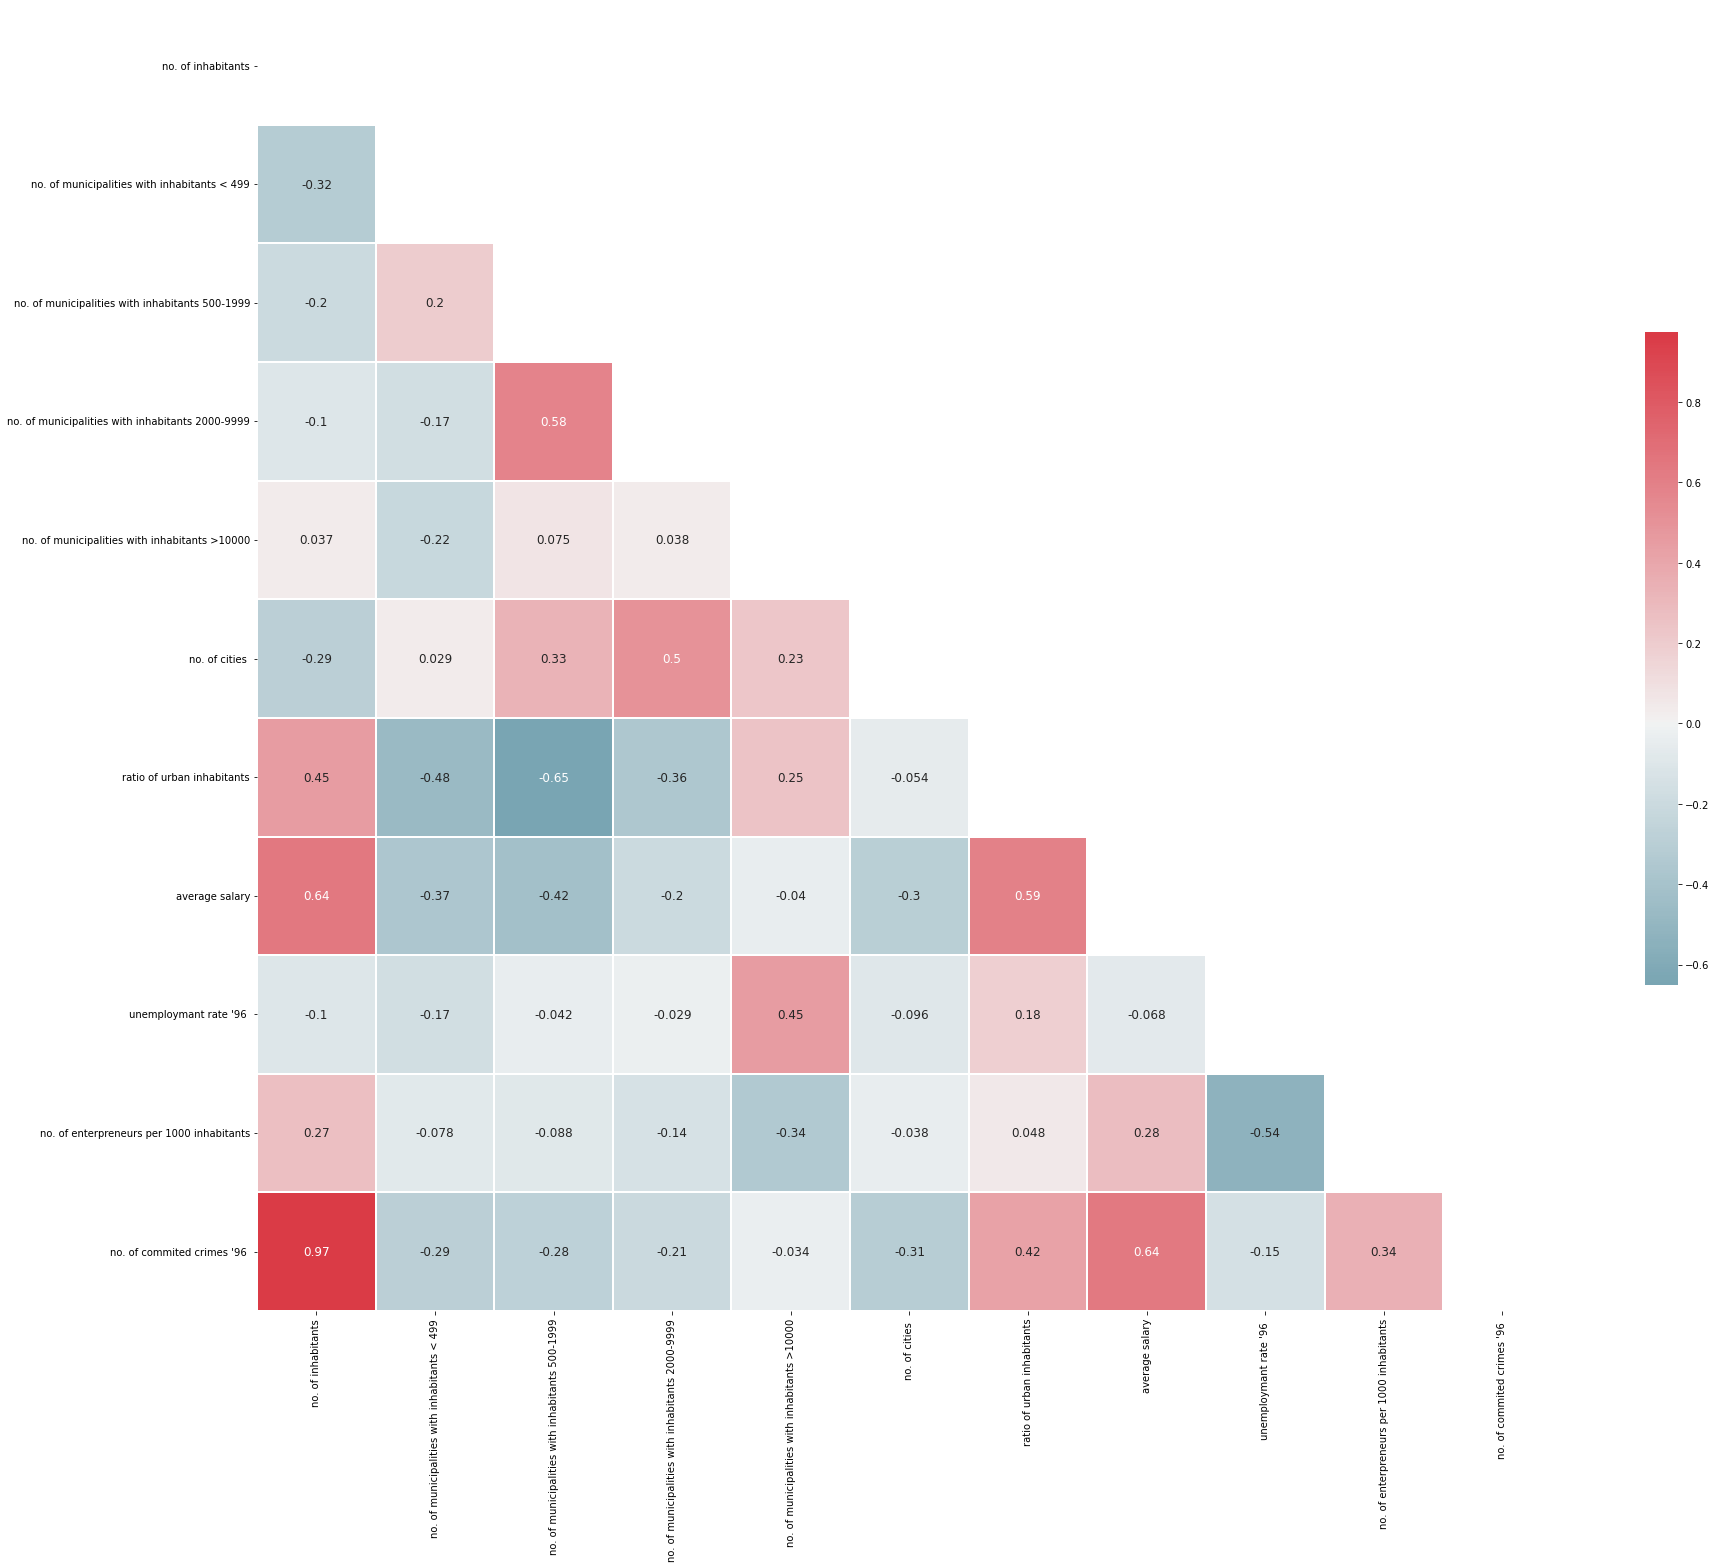

In [26]:
get_correlation(district_clean)

In [27]:
if DISPLAY_PAIRPLOTS:
    sns.pairplot(district, hue="region", palette="bright")
    plt.savefig('district_pairplot.svg')

### Features conclusions

- District `name` is unique for each district
- District missing values "?" should be replaced by median rather mean


## Transaction Analysis

In [28]:
display(trans_dev.head())
display(trans_dev.info())

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,1548749,5270,930113,credit,credit in cash,800.0,800.0,NaN,NaN,NaN
1,1548750,5270,930114,credit,collection from another bank,44749.0,45549.0,NaN,IJ,80269753.0
2,3393738,11265,930114,credit,credit in cash,1000.0,1000.0,NaN,NaN,NaN
3,3122924,10364,930117,credit,credit in cash,1100.0,1100.0,NaN,NaN,NaN
4,1121963,3834,930119,credit,credit in cash,700.0,700.0,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396685 entries, 0 to 396684
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   trans_id    396685 non-null  object 
 1   account_id  396685 non-null  object 
 2   date        396685 non-null  object 
 3   type        396685 non-null  object 
 4   operation   325924 non-null  object 
 5   amount      396685 non-null  float64
 6   balance     396685 non-null  float64
 7   k_symbol    211441 non-null  object 
 8   bank        97242 non-null   object 
 9   account     102229 non-null  float64
dtypes: float64(3), object(7)
memory usage: 30.3+ MB


None

Text(0, 0.5, 'Balance')

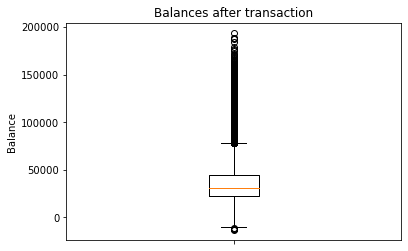

In [29]:
plt.title("Balances after transaction")
plt.boxplot(trans_dev["balance"].astype('int'))
plt.xticks([1], [''])
plt.ylabel('Balance')

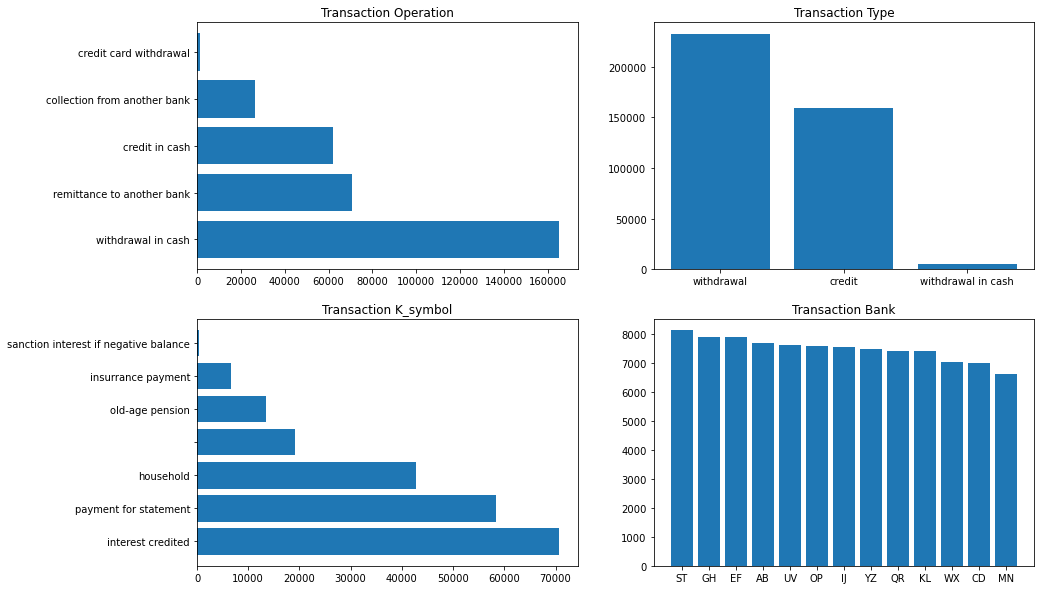

In [30]:
trans_type = trans_dev["type"].value_counts()
trans_operation = trans_dev["operation"].value_counts()
trans_k_symbol = trans_dev["k_symbol"].value_counts()
trans_bank = trans_dev["bank"].value_counts()

fig, ((ax2, ax1), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
ax1.title.set_text("Transaction Type")
ax1.bar(list(trans_type.keys()), list(trans_type))
ax2.title.set_text("Transaction Operation")
ax2.barh(list(trans_operation.keys()), list(trans_operation))
ax3.title.set_text("Transaction K_symbol")
ax3.barh(list(trans_k_symbol.keys()), list(trans_k_symbol))
ax4.title.set_text("Transaction Bank")
ax4.bar(list(trans_bank.keys()), list(trans_bank))
plt.show()

In [31]:
trans_dev_no_mv = pd.read_csv('data_processed/trans_dev_no_mv.csv', dtype={'account_id':object, 'trans_id':object, 'date':object, 'type':object, 'operation':object, 'k_symbol':object, 'bank':object, 'account':object})

In [32]:
display(trans_dev_no_mv.head())
display(trans_dev_no_mv.info())
display(trans_dev_no_mv.describe())
display(trans_dev_no_mv.describe(include=object))

,trans_id,account_id,date,type,operation,amount,balance,k_symbol
0,1548749,5270,930113,credit,credit in cash,800.0,800.0,NaN
1,1548750,5270,930114,credit,collection from another bank,44749.0,45549.0,NaN
2,3393738,11265,930114,credit,credit in cash,1000.0,1000.0,NaN
3,3122924,10364,930117,credit,credit in cash,1100.0,1100.0,NaN
4,1121963,3834,930119,credit,credit in cash,700.0,700.0,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396685 entries, 0 to 396684
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   trans_id    396685 non-null  object 
 1   account_id  396685 non-null  object 
 2   date        396685 non-null  object 
 3   type        396685 non-null  object 
 4   operation   396685 non-null  object 
 5   amount      396685 non-null  float64
 6   balance     396685 non-null  float64
 7   k_symbol    192376 non-null  object 
dtypes: float64(2), object(6)
memory usage: 24.2+ MB


None

,amount,balance
count,396685.000000,396685.000000
mean,5677.552980,35804.792507
std,9190.364137,19692.148243
min,0.000000,-13588.700000
25%,127.500000,22424.300000
50%,1952.000000,30959.600000
75%,6500.000000,44661.000000
max,86400.000000,193909.900000


,trans_id,account_id,date,type,operation,k_symbol
count,396685,396685,396685,396685,396685,192376
unique,396685,3370,1461,2,4,6
top,1548749,2932,961231,withdrawal,withdrawal in cash,interest credited
freq,1,441,5472,237217,166480,70761


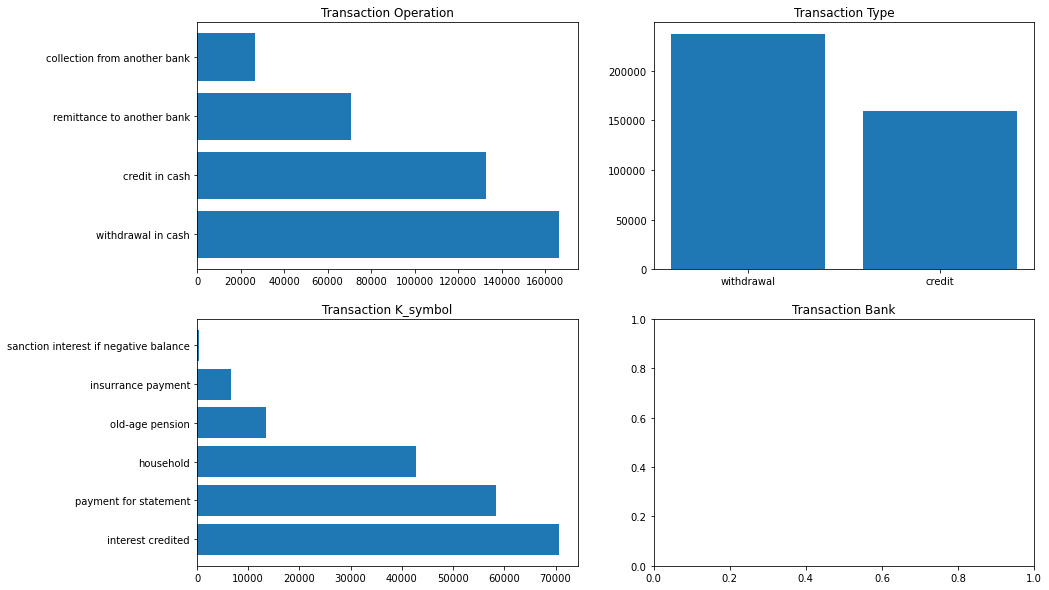

In [33]:
trans_type = trans_dev_no_mv["type"].value_counts()
trans_operation = trans_dev_no_mv["operation"].value_counts()
trans_k_symbol = trans_dev_no_mv["k_symbol"].value_counts()

fig, ((ax2, ax1), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
ax1.title.set_text("Transaction Type")
ax1.bar(list(trans_type.keys()), list(trans_type))
ax2.title.set_text("Transaction Operation")
ax2.barh(list(trans_operation.keys()), list(trans_operation))
ax3.title.set_text("Transaction K_symbol")
ax3.barh(list(trans_k_symbol.keys()), list(trans_k_symbol))
ax4.title.set_text("Transaction Bank")
plt.show()

In [34]:
# Describe mean balance for each account

balance_mean_by_account = trans_dev_no_mv.groupby('account_id')['balance'].mean()
display(balance_mean_by_account.describe())


count     3370.000000
mean     32661.207285
std      15413.094042
min        200.000000
25%      21703.451760
50%      30676.254970
75%      42946.517635
max      82499.700000
Name: balance, dtype: float64

In [35]:
# Describe mean transaction amount for each transaction type

amount_mean_by_transaction_type = trans_dev_no_mv.groupby('type')['amount'].mean()
display(amount_mean_by_transaction_type)

amount_mean_by_transaction_operation = trans_dev_no_mv.groupby('operation')['amount'].mean()
display(amount_mean_by_transaction_operation)

type
credit        7434.713441
withdrawal    4496.310217
Name: amount, dtype: float64

operation
collection from another bank    10330.615544
credit in cash                   6857.440927
remittance to another bank       3048.708498
withdrawal in cash               5111.393127
Name: amount, dtype: float64

In [36]:
aux = trans_dev_no_mv.copy()
aux['date_ts'] = convert_date(aux['date'])
aux['ts'] = pd.to_datetime(aux['date_ts']).astype(int)/ 10**9
aux = aux.drop(['k_symbol'], axis=1)
aux = aux.drop(['trans_id', 'account_id'], axis=1)

display(aux.head())
from sklearn.preprocessing import OrdinalEncoder
le = OrdinalEncoder()
ordinal_cols = [col for col in ['type', 'operation'] if col in aux.keys()]
aux[ordinal_cols] = le.set_params(encoded_missing_value=-1).fit_transform(aux[ordinal_cols])
display(le.feature_names_in_)
display(aux.head())


if DISPLAY_PAIRPLOTS:
    sns.pairplot(aux, hue="operation", palette="bright")

,date,type,operation,amount,balance,date_ts,ts
0,930113,credit,credit in cash,800.0,800.0,1993-01-13,726883200.0
1,930114,credit,collection from another bank,44749.0,45549.0,1993-01-14,726969600.0
2,930114,credit,credit in cash,1000.0,1000.0,1993-01-14,726969600.0
3,930117,credit,credit in cash,1100.0,1100.0,1993-01-17,727228800.0
4,930119,credit,credit in cash,700.0,700.0,1993-01-19,727401600.0


array(['type', 'operation'], dtype=object)

,date,type,operation,amount,balance,date_ts,ts
0,930113,0.0,1.0,800.0,800.0,1993-01-13,726883200.0
1,930114,0.0,0.0,44749.0,45549.0,1993-01-14,726969600.0
2,930114,0.0,1.0,1000.0,1000.0,1993-01-14,726969600.0
3,930117,0.0,1.0,1100.0,1100.0,1993-01-17,727228800.0
4,930119,0.0,1.0,700.0,700.0,1993-01-19,727401600.0


### Features conclusions
- Transaction `type` "withdrawal in cash" is most likely an input error so it should be "withdrawal"
- Transaction `operation` "credit card withdrawal" looks like it is logically irrelevant
- Transaction `operation` has null values but it has potential to be an important feature since it describes the transaction
- Transaction `k_symbol` has empty values besides NaN, they can be considered as NaN

## Loan Analysis

In [37]:
display(loan_dev.head())
display(loan_dev.info())
display(loan_dev.describe())
display(loan_dev.describe(include=object))


,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,930705,96396,12,8033,-1
1,5316,1801,930711,165960,36,4610,1
2,6863,9188,930728,127080,60,2118,1
3,5325,1843,930803,105804,36,2939,1
4,7240,11013,930906,274740,60,4579,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   loan_id     328 non-null    object
 1   account_id  328 non-null    object
 2   date        328 non-null    object
 3   amount      328 non-null    int64 
 4   duration    328 non-null    int64 
 5   payments    328 non-null    int64 
 6   status      328 non-null    int64 
dtypes: int64(4), object(3)
memory usage: 18.1+ KB


None

,amount,duration,payments,status
count,328.000000,328.000000,328.000000,328.000000
mean,145308.621951,35.853659,4150.932927,0.719512
std,105247.318098,16.734752,2193.620989,0.695541
min,4980.000000,12.000000,319.000000,-1.000000
25%,68328.000000,24.000000,2368.750000,1.000000
50%,114804.000000,36.000000,3878.500000,1.000000
75%,198600.000000,48.000000,5907.750000,1.000000
max,538500.000000,60.000000,9689.000000,1.000000


,loan_id,account_id,date
count,328,328,328
unique,328,328,283
top,5314,1787,951212
freq,1,1,3


In [38]:
loan_dev['date_ts'] = convert_date(loan_dev['date'])
print(loan_dev['date_ts'].min())
print(loan_dev['date_ts'].max())

1993-07-05
1996-12-27


The plot below shows that a big majority of the loans were given, what represents a strng imbalance in the target column. This situation usally leads models to have the tendency to opt for the class more populated, in this case answering 'yes' to the loan.

<BarContainer object of 2 artists>

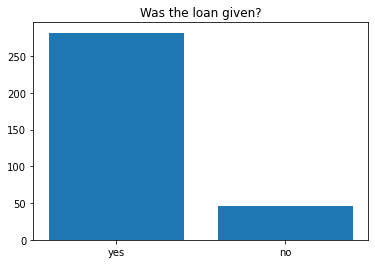

In [39]:
loan_status = loan_dev['status'].value_counts()
plt.title("Was the loan given?")
plt.bar(['yes', 'no'], list(loan_status))

In the box plot and histogram below we can see that the duration of the loans has a uniform distribution.

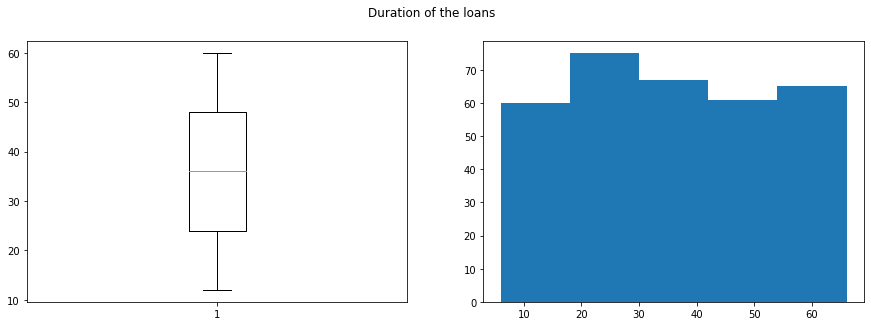

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 4.8)
fig.suptitle("Duration of the loans")

ax1.boxplot(loan_dev["duration"])
ax2.hist(loan_dev["duration"].values, [6, 18, 30, 42, 54, 66])
plt.show()

In the box plot and histogram below we can see that the amount of money requested for loans looks like a poisson distribution. The density of the data until the median is much greater than after it. Also, in the box plot, it's poossible to verify the existence of some outliers.

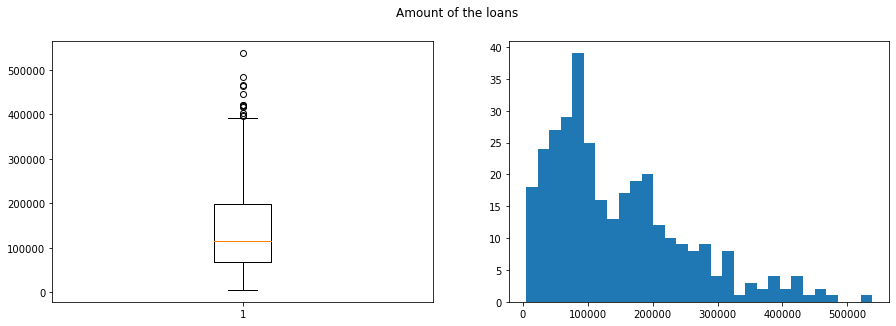

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 4.8)
fig.suptitle("Amount of the loans")

ax1.boxplot(loan_dev["amount"])
ax2.hist(loan_dev["amount"].values, 30)
plt.show()

By observation of the below scatter plots and histograms, we can conclude that the duration of the loan is not connected with the status of the loan since it have an uniform distribution. On the other hand, either the amount and the payments looks like they can be related since the percentage of negative status in higher payments and amounts is greater than it is in the lower ones.

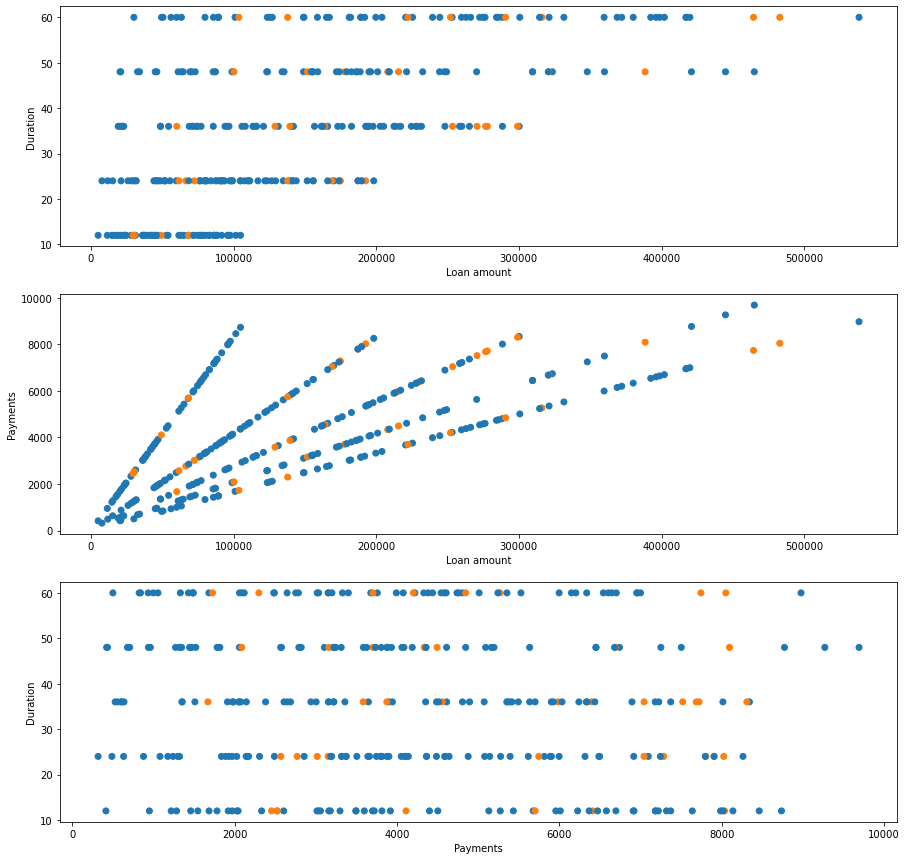

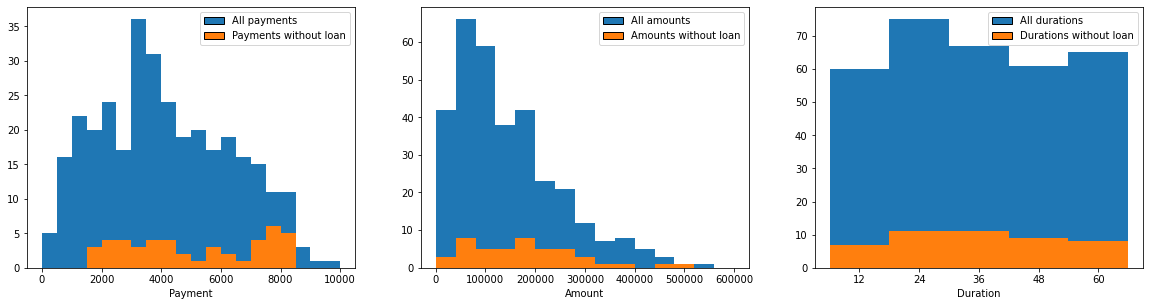

In [42]:
from matplotlib.patches import Rectangle


amount = loan_dev['amount']
duration = loan_dev['duration']
payments = loan_dev['payments']

colors = ['C0' if s == 1 else 'C1' for s in loan_dev['status']]

fig, (ax1, ax2,  ax3) = plt.subplots(3, figsize=[15, 15])
ax1.scatter(amount, duration, color=colors)
ax1.set_xlabel('Loan amount')
ax1.set_ylabel('Duration')
ax2.scatter(amount, payments, color=colors)
ax2.set_xlabel('Loan amount')
ax2.set_ylabel('Payments')
ax3.scatter(payments, duration, color=colors)
ax3.set_xlabel('Payments')
ax3.set_ylabel('Duration')
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[20, 4.8])
handles = [Rectangle((0, 0), 1, 1, color=c, ec="k") for c in ['C0', 'C1']]

ax1.hist(payments, list(range(0, 10001, 500)), color='C0')
ax1.hist(loan_dev.query('status == -1')['payments'], list(range(0, 10001, 500)), color='C1')
ax1.set_xlabel('Payment')
ax1_labels = ["All payments", "Payments without loan"]
ax1.legend(handles, ax1_labels)

ax2.hist(amount, list(range(0, 600001, 40000)), color='C0')
ax2.hist(loan_dev.query('status == -1')['amount'], list(range(0, 600001, 40000)), color='C1')
ax2.set_xlabel('Amount')
ax2_labels = ["All amounts", "Amounts without loan"]
ax2.legend(handles, ax2_labels)

ax3.hist(duration, list(range(6, 70, 12)), color='C0')
ax3.hist(loan_dev.query('status == -1')['duration'], list(range(6, 70, 12)), color='C1')
ax3.set_xlabel('Duration')
ax3.set_xticks(list(range(12, 61, 12)))
ax3_labels = ["All durations", "Durations without loan"]
ax3.legend(handles, ax3_labels)
plt.show()

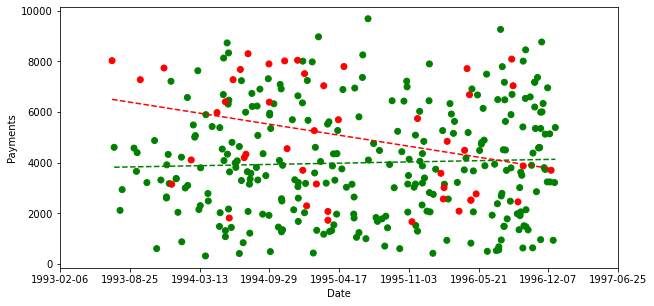

In [43]:
from datetime import date

date_ts1 = loan_dev.query('status == 1')['date_ts'].apply(lambda x: x.toordinal())
payments1 = loan_dev.query('status == 1')['payments']

date_ts2 = loan_dev.query('status == -1')['date_ts'].apply(lambda x: x.toordinal())
payments2 = loan_dev.query('status == -1')['payments']

z1 = np.polyfit(date_ts1, payments1, 1)
p1 = np.poly1d(z1)
z2 = np.polyfit(date_ts2, payments2, 1)
p2 = np.poly1d(z2)

plt.figure(figsize=[10, 4.8])
plt.scatter(date_ts1, payments1, color=['g' for _ in range(len(date_ts1))])
plt.plot(date_ts1, p1(date_ts1), "g--")
plt.scatter(date_ts2, payments2, color=['r' for _ in range(len(date_ts2))])
plt.plot(date_ts2, p2(date_ts2), "r--")
aux = plt.xticks()
new_labels = [date.fromordinal(int(item)) for item in aux[0]]
plt.xticks(aux[0], new_labels)
plt.xlabel('Date')
plt.ylabel('Payments')
plt.show()

### Features conclusions
- Loan `duration` doesn't seems to be relevant for the `status` since the distribution porportion is similar for both status
- Loan higher `payments` leads to a greater probability of a `status` of -1
- Loan `payments` correspondent to `status` -1 decrease along the time

## Integrated Data Analysis

In [44]:
# Get data selected
data_selected = pd.read_csv('data_processed/complete/data_selected.csv')
target_selected = data_selected['status']
data_selected_no_id = data_selected.drop('loan_id', axis=1)
data_selected_no_status = data_selected.drop('status', axis=1)
data_selected_features = data_selected.drop(['status', 'loan_id'], axis=1)

status
-1    2966.5
 1    4566.5
Name: monthly_diff, dtype: float64

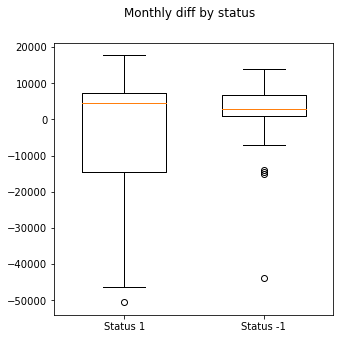

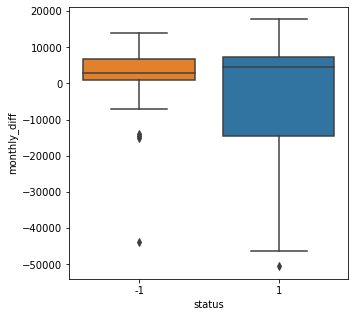

In [45]:
# Relation between status and monthly_diff
status_median_monthly_diff = data.groupby('status')['monthly_diff'].median()
display(status_median_monthly_diff)

aux = {'Status 1': data[data['status'] == 1]['monthly_diff'].values, 'Status -1': data[data['status'] == -1]['monthly_diff'].values}
fig, ax = plt.subplots(figsize=(5, 5))
fig.suptitle('Monthly diff by status')
ax.boxplot(aux.values(), widths=0.6)
ax.set_xticklabels(aux.keys())
plt.show()

fig, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(data=data, x="status", y="monthly_diff", palette=["C1", "C0"], ax=ax)
plt.show()

The plot below indicates that the gender of the client that requested the loan have no significant impact on the choice of loan or not.

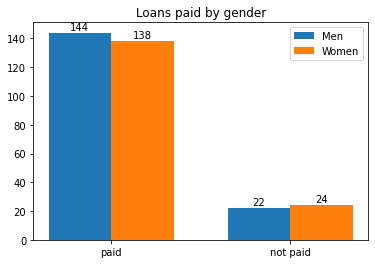

In [46]:
labels = ['paid', 'not paid']
aux = data.groupby('gender')['status'].value_counts()
female = aux[:2]
male = aux[2:]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, male, width, label='Men')
rects2 = ax.bar(x + width/2, female, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Loans paid by gender')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=1)
ax.bar_label(rects2, padding=1)
plt.show()

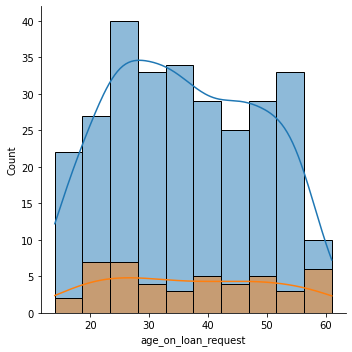

In [47]:
# Age on loan request
sns.displot(data=data, x="age_on_loan_request", kde=True, hue="status", palette=['C1', 'C0'], legend=False)
plt.show()

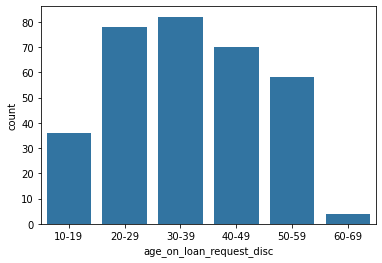

In [48]:
data_sorted = data.sort_values(by=["age_on_loan_request_disc"])
sns.countplot(x=data_sorted["age_on_loan_request_disc"], color='C0')
plt.show()

In [49]:
# Influence of having a disponent on loan request
data[data['has_disponent'] == 1]['status'].value_counts()

1    75
Name: status, dtype: int64

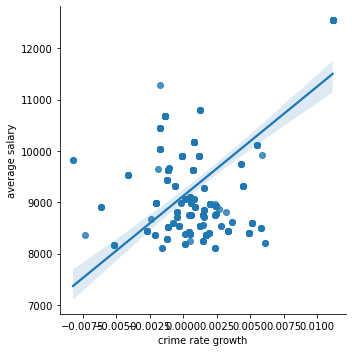

In [50]:
# Linear regression
sns.lmplot(data=data, x="crime rate growth", y="average salary")
plt.show()

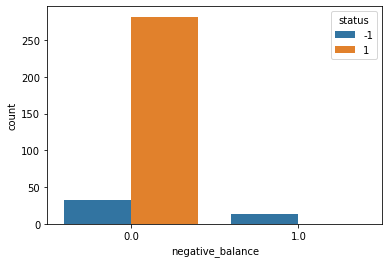

In [51]:
# Number of status per negative balance
sns.countplot(data=data, x="negative_balance", hue="status")
plt.show()

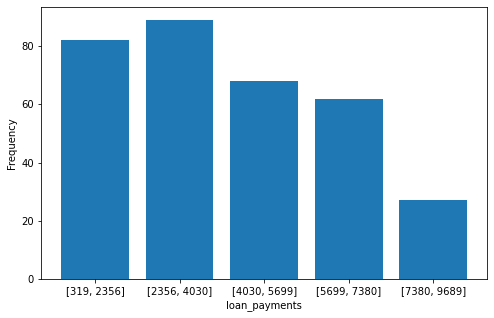

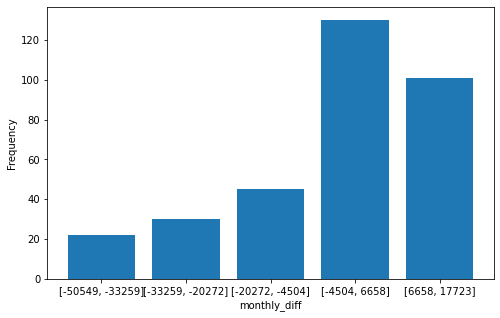

In [52]:
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer

def plot_bins(name, values, bins):
    """visualizes the number of observations in each bin"""
    
    counter = Counter(values)
    plt.figure(figsize=[8, 5])
    plt.bar(counter.keys(), counter.values())
    plt.xlabel(name)
    plt.ylabel('Frequency')
    ticks = list(counter.keys())
    ticks.sort()
    labels = [f'[{str(round(bins[i]))}, {str(round(bins[i+1]))}]' for i in range(len(bins)-1)]
    plt.xticks(ticks, labels)
    plt.show() 

def show_bins(bins):
    """Shows the ranges of values the bins comprises"""
    
    for i in range(len(bins)-1):
        print(f'Bin {i}: {str(bins[i])} -> {str(bins[i+1])}')

# show results
kbins = KBinsDiscretizer(n_bins=5, strategy='kmeans', encode='ordinal')
payments_bin = kbins.fit_transform(np.array(data['loan_payments']).reshape(-1,1))
plot_bins('loan_payments', Counter(list(payments_bin.flatten())), kbins.bin_edges_[0])
# show_bins(kbins.bin_edges_[0])

# show results
kbins = KBinsDiscretizer(n_bins=5, strategy='kmeans', encode='ordinal')
monthly_diff_bin = kbins.fit_transform(np.array(data['monthly_diff']).reshape(-1,1))
plot_bins('monthly_diff', Counter(list(monthly_diff_bin.flatten())), kbins.bin_edges_[0])
# show_bins(kbins.bin_edges_[0])

### Correlation Map

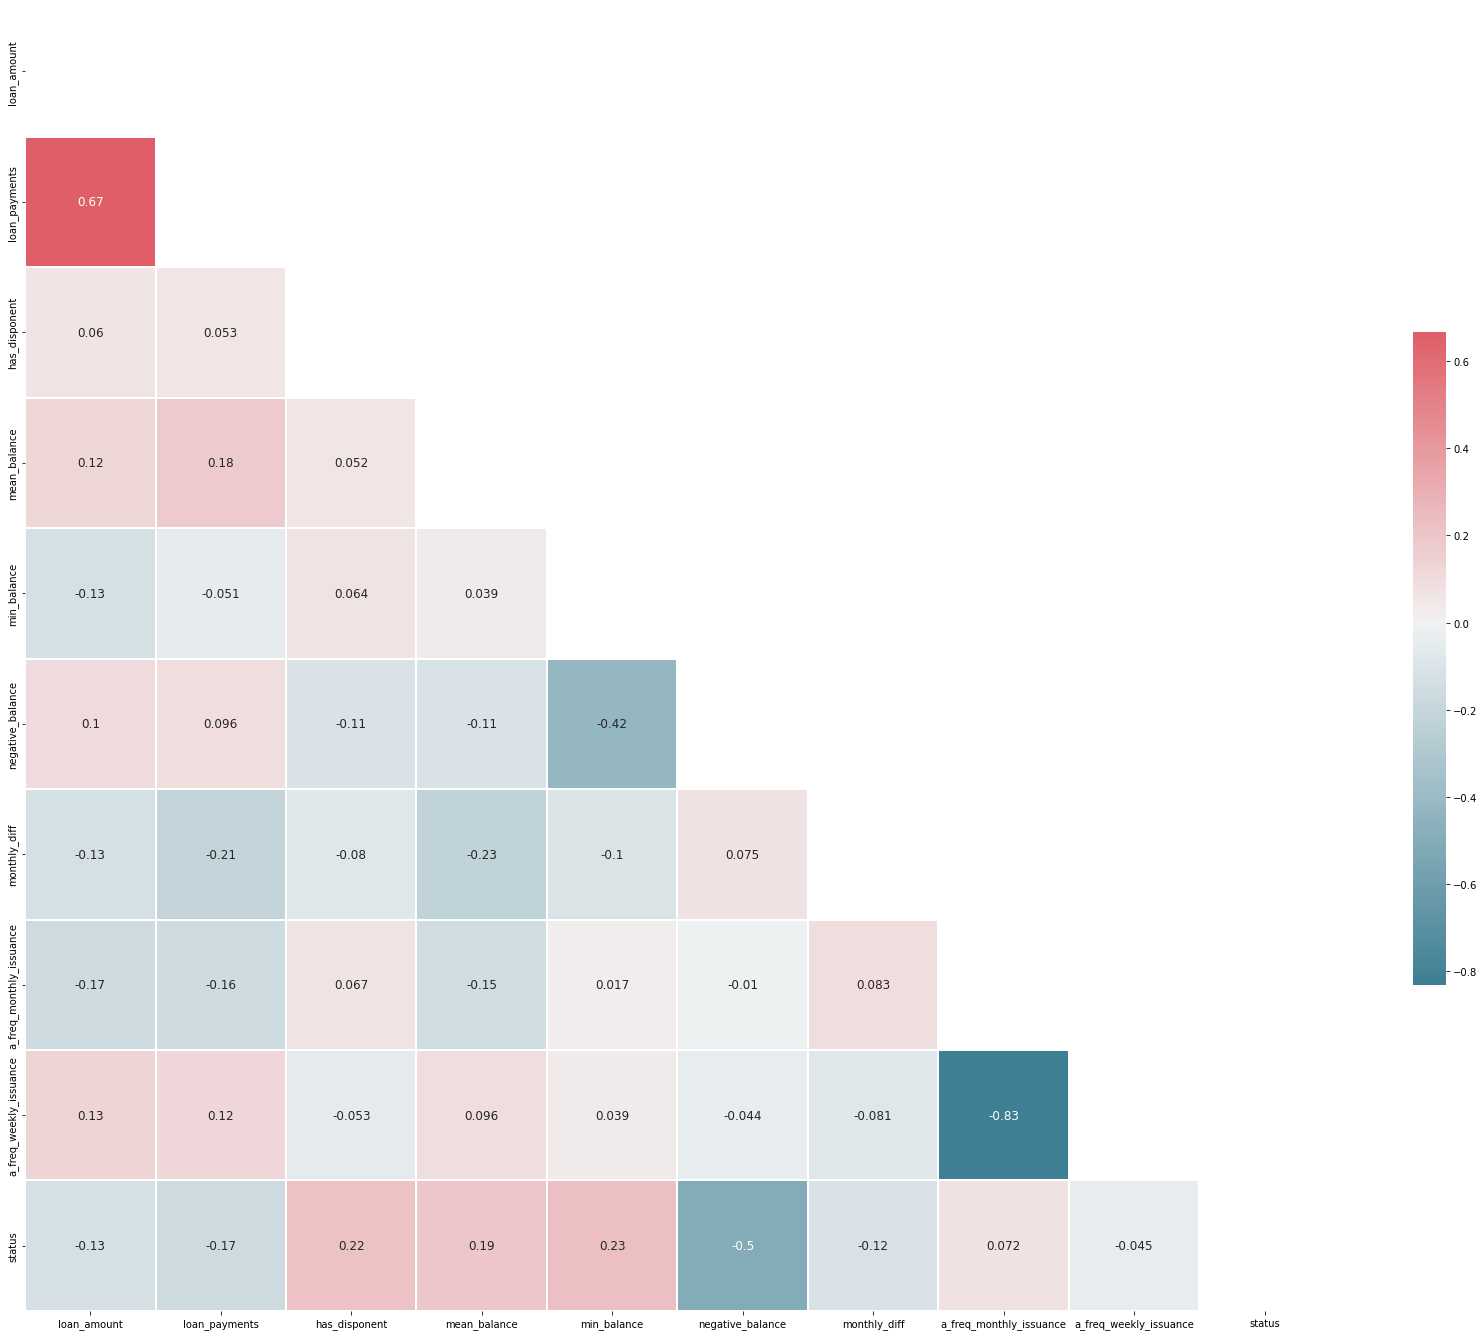

In [53]:
data.rename(columns={'no. of municipalities with inhabitants < 499': 'n_municip_499', 'no. of municipalities with inhabitants 500-1999': 'n_municip_1999', 'no. of municipalities with inhabitants > 2000': 'n_municip_2000'}, inplace=True)

SELECTED = True
if SELECTED:
    get_correlation(data_selected_no_id)
else:
    # no_ids = [c for c in data.columns if c[-3:] != '_id' and c != 'code']
    no_ids = [c for c in data.columns]
    no_ids.remove('status')
    no_ids.append('status')

    get_correlation(data[no_ids])

### Principal Component Analysis (PCA)

[0.24302743 0.17868117]


array([[ 0.43430702,  0.44476805,  0.01342409,  0.25747792, -0.03925901,
         0.03455443, -0.23913845, -0.50677037,  0.47994273],
       [-0.36725628, -0.32701003,  0.05175757,  0.11632502,  0.51921672,
        -0.5360208 , -0.09217602, -0.26811558,  0.32355868]])

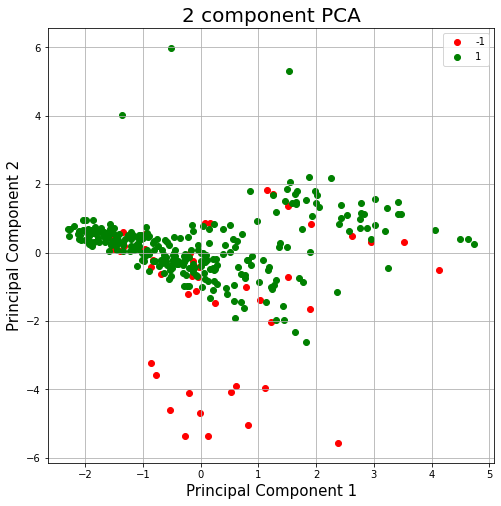

In [54]:
SELECTED = True
if SELECTED:
    from sklearn.preprocessing import StandardScaler

    # Standardizing the features
    data_selected_features_scaled = StandardScaler().fit_transform(data_selected_features)

    finalDf = get_PCA(data_selected_features_scaled)
    plot_PCA(finalDf, data[['status']])
